In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/")

Mounted at /content/drive


In [ ]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install torch-geometric==2.2.0
import torch
print(torch.__version__)
print(torch.version.cuda)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.1 requires torch==2.0.1, 

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector
def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net



In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
phe = True

if phe == False:
  save_phe = '/without_phe/'
else:
  save_phe = '/with_phe/'

save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_phe
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
  shutil.rmtree(root_path_fMRI)
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI)
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
  shutil.rmtree(localDir)
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'


k_fold = 5
new_number_features_fMRI = 4000
new_number_features_sMRI = 800
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]
scaler = True


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

EV_GCN_unique = list(unique_sites)
EV_GCN_site = np.zeros([number_samples - len(useless_samples)], dtype=np.int)
EV_GCN_age = np.zeros([number_samples - len(useless_samples)], dtype=np.float32)
EV_GCN_gender = np.zeros([number_samples - len(useless_samples)], dtype=np.int)

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]])
    position = position + 1

for i in range(number_samples - len(useless_samples)):

  EV_GCN_site[i] = EV_GCN_unique.index(sites[i])
  EV_GCN_age[i] = ages[i]
  EV_GCN_gender[i] = genders[i]

phonetic_data = np.zeros([number_samples - len(useless_samples), 3], dtype=np.float32)
phonetic_data[:,0] = EV_GCN_site
phonetic_data[:,1] = EV_GCN_gender
phonetic_data[:,2] = EV_GCN_age

pd_dict = {}
pd_dict['SITE_ID'] = np.copy(phonetic_data[:,0])
pd_dict['SEX'] = np.copy(phonetic_data[:,1])
pd_dict['AGE_AT_SCAN'] = np.copy(phonetic_data[:,2])


if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/aseg.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.DKTatlas.stats  
  inflating: /content/sM

<ipython-input-18-a40cd79c21e7>:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EV_GCN_site = np.zeros([number_samples - len(useless_samples)], dtype=np.int)
<ipython-input-18-a40cd79c21e7>:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

The index for sample 51334 is :  [799]


In [ ]:
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load Desikan_Killiany_features
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))


position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
						  skiprows=skiprows)
    table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
						  skiprows=skiprows)

    for j in range(len(feature_list)):
      feature_name = feature_list[j]
      left_features = table_left[feature_name].values.tolist()
      right_features = table_right[feature_name].values.tolist()
      all_features = left_features + right_features
      if len(all_features) != number_roi:
       print('The sample ' + subject_name + ' has mistake!')
      all_features = np.array(all_features)
      Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features
    position = position + 1

if scaler == True:
	for i in range(len(feature_list)):
		Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished')

############################################### Load aseg features
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
						  skiprows=skiprows_aseg)
		for j in range(len(feature_list_aseg)):
			feature_name = feature_list_aseg[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_aseg:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
		position = position + 1

if scaler == True:
	for i in range(len(feature_list_aseg)):
		aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished')

############################################### Load wmparc features
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
						  skiprows=skiprows_wmparc)
		for j in range(len(feature_list_wmparc)):
			feature_name = feature_list_wmparc[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_wmparc:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features
		position = position + 1
if scaler == True:
	for i in range(len(feature_list_wmparc)):
		wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished')

############################################### concatenation
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished
constructing aseg features
The index for sample 51334 is :  [799]
finished
constructing wmparc features
The index for sample 51334 is :  [799]
finished


In [ ]:
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
ages_name = 'ages.mat'
ages = scio.loadmat(os.path.join(label_dir, ages_name))
ages = ages['ages']

gender_name = 'genders.mat'
genders = scio.loadmat(os.path.join(label_dir, gender_name))
genders = genders['genders']

FIQ_name = 'FIQS.mat'
FIQS = scio.loadmat(os.path.join(label_dir, FIQ_name))
FIQS = FIQS['FIQS']

NUM_name = 'NUM.mat'
NUM = scio.loadmat(os.path.join(label_dir, NUM_name))
NUMS = NUM['NUM']

PEC_name = 'PEC.mat'
PEC = scio.loadmat(os.path.join(label_dir, PEC_name))
PECS = PEC['PEC']

RAT_name = 'RAT.mat'
RAT = scio.loadmat(os.path.join(label_dir, RAT_name))
RATS = RAT['RAT']

age = np.zeros((number_samples - len(useless_samples), 1))
gender = np.zeros((number_samples - len(useless_samples), 1))
FIQ = np.zeros((number_samples - len(useless_samples), 1))
NUM = np.zeros((number_samples - len(useless_samples), 1))
PEC = np.zeros((number_samples - len(useless_samples), 1))
RAT = np.zeros((number_samples - len(useless_samples), 1))

position = 0
print('constructing phenotypic features')
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		age[position] = float(ages[subject_index[0]].replace(' ', ''))
		gender[position] = int(genders[subject_index[0]]) + 1
		FIQ[position] = int(FIQS[subject_index[0]])
		NUM[position] = float(NUMS[subject_index[0]])
		PEC[position] = float(PECS[subject_index[0]])
		RAT[position] = int(RATS[subject_index[0]])
		position = position + 1
FIQ[FIQ == -9999] = 108

if scaler == True:

  age[:,0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(age[:,0], axis = 1)))
  FIQ[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(FIQ[:, 0], axis = 1)))
  NUM[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(NUM[:, 0], axis = 1)))
  PEC[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(PEC[:, 0], axis = 1)))

# age, gender, FIQ, NUM, PEC, RAT
phe_features = np.concatenate((age, gender, FIQ, NUM, PEC, RAT),axis = 1)
print(phe_features.shape)


constructing phenotypic features
The index for sample 51334 is :  [799]
(870, 6)


In [ ]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1


for i in range(k_fold):
	print(len(dist_test[str(i+1)]))

177
174
170
167
182


In [ ]:
import torch
import torch_geometric as tg
from torch.nn import Linear as Lin, Sequential as Seq
import torch.nn.functional as F
from torch import nn

############################################### PAE and EV-GCN ###############################################################
############################################### PAE and EV-GCN ###############################################################
############################################### PAE and EV-GCN ###############################################################
class PAE(torch.nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(PAE, self).__init__()
        hidden=128
        self.parser =nn.Sequential(
                nn.Linear(input_dim, hidden, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden),
                nn.Dropout(dropout),
                nn.Linear(hidden, hidden, bias=True),
                )
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-8)
        self.input_dim = input_dim
        self.model_init()
        self.relu = nn.ReLU(inplace=True)
        self.elu = nn.ReLU()

    def forward(self, x):
        x1 = x[:,0:self.input_dim]
        x2 = x[:,self.input_dim:]
        h1 = self.parser(x1)
        h2 = self.parser(x2)
        p = (self.cos(h1,h2) + 1)*0.5
        return p

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True


class EV_GCN(torch.nn.Module):
    def __init__(self, input_dim, num_classes, dropout, edgenet_input_dim, edge_dropout, hgc, lg):
        super(EV_GCN, self).__init__()
        K=2
        hidden = [hgc for i in range(lg)]
        self.dropout = dropout
        self.edge_dropout = edge_dropout
        bias = False
        self.relu = torch.nn.ReLU(inplace=True)
        self.lg = lg
        self.gconv = nn.ModuleList()
        for i in range(lg):
            in_channels = input_dim if i==0  else hidden[i-1]
            self.gconv.append(tg.nn.ChebConv(in_channels, hidden[i], K, normalization='sym', bias=bias))
        cls_input_dim = sum(hidden)

        self.cls = nn.Sequential(
                torch.nn.Linear(cls_input_dim, 256),
                torch.nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                torch.nn.Linear(256, num_classes))

        self.edge_net = PAE(input_dim=edgenet_input_dim//2, dropout=dropout)
        self.model_init()
        self.softmax = nn.LogSoftmax(dim=1)

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, features, edge_index, edgenet_input, enforce_edropout=False):
        if self.edge_dropout>0:
            if enforce_edropout or self.training:
                one_mask = torch.ones([edgenet_input.shape[0],1]).cuda()
                self.drop_mask = F.dropout(one_mask, self.edge_dropout, True)
                self.bool_mask = torch.squeeze(self.drop_mask.type(torch.bool))
                edge_index = edge_index[:, self.bool_mask]
                edgenet_input = edgenet_input[self.bool_mask]


        edge_weight = torch.squeeze(self.edge_net(edgenet_input))
        features = F.dropout(features, self.dropout, self.training)
        h = self.relu(self.gconv[0](features, edge_index, edge_weight))
        h0 = h
        for i in range(1, self.lg):
            h = F.dropout(h, self.dropout, self.training)
            h= self.relu(self.gconv[i](h, edge_index, edge_weight))
            jk = torch.cat((h0, h), axis=1)
            h0 = jk
        logit = self.cls(jk)


        return self.softmax(logit), edge_weight

In [ ]:
EV_GCN_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        EV_GCN_labels[i,0] = 1
    else:
        EV_GCN_labels[i,1] = 1


all_subject_IDs = get_ids(number_samples,dir_path=label_dir)
all_subject_IDs = all_subject_IDs.tolist()
for i in useless_samples:
    subject_IDs.remove(i)

In [ ]:
from scipy.spatial import distance

def create_affinity_graph_from_scores(scores, pd_dict):
    num_nodes = len(pd_dict[scores[0]])
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = pd_dict[l]

        if l in ['AGE_AT_SCAN', 'FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[k]) - float(label_dict[j]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass

        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[k] == label_dict[j]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph

def get_static_affinity_adj(features, pd_dict):
    pd_affinity = create_affinity_graph_from_scores(['SEX', 'SITE_ID'], pd_dict)
    distv = distance.pdist(features, metric='correlation')
    dist = distance.squareform(distv)
    sigma = np.mean(dist)
    feature_sim = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adj = pd_affinity * feature_sim

    return adj




data = {}
for fold in range(1, k_fold+1):
  data[str(fold)] = []
  selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
  selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

  new_fMRI_data = selector_fMRI.transform(fMRI_images)
  new_sMRI_data = selector_sMRI.transform(sMRI_features)
  ################################################# combine ##########################################
  if phe == True:
    fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
    print(fold_data.shape)
  else:
    fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
    print(fold_data.shape)

  n = fold_data.shape[0]
  num_edge = n * n
  edge_index = np.zeros([2, num_edge], dtype=np.int64)
  edgenet_input = np.zeros([num_edge, 2*phonetic_data.shape[1]], dtype=np.float32)
  aff_score = np.zeros(num_edge, dtype=np.float32)

  aff_adj = get_static_affinity_adj(fold_data, pd_dict)

########################################################## Change #########################################################################
########################################################## Change #########################################################################
########################################################## Change #########################################################################
# !!! Must enter the entire the whole population graph instead of the upper triangle area, otherwise information leakage will occur

  flatten_ind = 0
  for i in range(n):
    for j in range(n):
      edge_index[:, flatten_ind] = [i, j]
      edgenet_input[flatten_ind] = np.concatenate((phonetic_data[i], phonetic_data[j]))
      aff_score[flatten_ind] = aff_adj[i][j]
      flatten_ind += 1
########################################################## Change #########################################################################
########################################################## Change #########################################################################
########################################################## Change #########################################################################

  keep_ind = np.where(aff_score > 1.1)[0]
  edge_index = edge_index[:, keep_ind]
  edgenet_input = edgenet_input[keep_ind]
  edgenet_input = (edgenet_input- edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)

  print(fold_data)
  data[str(fold)].append(fold_data)
  data[str(fold)].append(EV_GCN_labels)
  data[str(fold)].append(edge_index)
  data[str(fold)].append(edgenet_input)

Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

In [ ]:
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
def train_EV_GCN(args, model, all_data, fold_train_index, fold_validation_index, fold_test_index, scheduler):

    model.train()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=True)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=True)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    scheduler.zero_grad()
    out, _ = model(data, edge_index, edgenet_input)
    out = out[fold_train_index,:]
    target = target[fold_train_index, :]

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1]) # only train set will be included
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    cross_loss.backward()
    scheduler.step()

    ############################## validation and test ################################################################################
    val_target, val_out, val_loss = validation_EV_GCN(args, model, all_data, fold_validation_index)
    test_target, test_out, test_out_prob, test_loss = test_EV_GCN(args, model, all_data, fold_test_index)

    return model, target, out, cross_loss.item(), val_target, val_out,val_loss, test_target, test_out, test_out_prob, test_loss


def validation_EV_GCN(args, model,all_data,  fold_validation_index):

    model.eval()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data, edge_index, edgenet_input)
    out = out[fold_validation_index, :]
    target = target[fold_validation_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    return target, out, cross_loss.item()


def test_EV_GCN(args, model, all_data,  fold_test_index):

    model.eval()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data, edge_index, edgenet_input)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()


    return target, out, out_prob, cross_loss.item()



In [ ]:
########################################### Training setting ################################################
########################################### Training setting ################################################
########################################### Training setting ################################################
torch.cuda.empty_cache()
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--nEpochs', type=int, default=200)
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--input_dimension', type=int, default=fold_data.shape[1])
parser.add_argument('--hgc', type=int, default=16, help='hidden units of gconv layer')
parser.add_argument('--lg', type=int, default=4, help='number of gconv layers')
parser.add_argument('--lr', default=0.01, type=float, help='initial learning rate')
parser.add_argument('--wd', default=5e-5, type=float, help='weight decay')
parser.add_argument('--num_iter', default=300, type=int, help='number of epochs for training')
parser.add_argument('--edropout', type=float, default=0.3, help='edge dropout rate')
parser.add_argument('--dropout', default=0.2, type=float, help='ratio of dropout')
parser.add_argument('--num_classes', type=int, default=2, help='number of classes')

#
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

gpu_ids = range(args.ngpu)
train = train_EV_GCN


  + Number of params: 190274
Save models
Train Epoch: 1: train loss : 0.98950404	 train accuracy : 0.51272016	 val accuracy : 0.50000000	 test accuracy : 0.51977401	
Save models
Train Epoch: 2: train loss : 0.93948185	 train accuracy : 0.52837573	 val accuracy : 0.53296703	 test accuracy : 0.54237288	
Save models
Train Epoch: 3: train loss : 1.12449861	 train accuracy : 0.50684932	 val accuracy : 0.53846154	 test accuracy : 0.51977401	
Train Epoch: 4: train loss : 0.79649121	 train accuracy : 0.61252446	 val accuracy : 0.53296703	 test accuracy : 0.50282486	
Save models
Train Epoch: 5: train loss : 0.77513766	 train accuracy : 0.60078278	 val accuracy : 0.54945055	 test accuracy : 0.49717514	
Save models
Train Epoch: 6: train loss : 0.81393260	 train accuracy : 0.60665362	 val accuracy : 0.54945055	 test accuracy : 0.54237288	
Save models
Train Epoch: 7: train loss : 0.67381072	 train accuracy : 0.66340509	 val accuracy : 0.57142857	 test accuracy : 0.57062147	
Save models
Train Epoch:

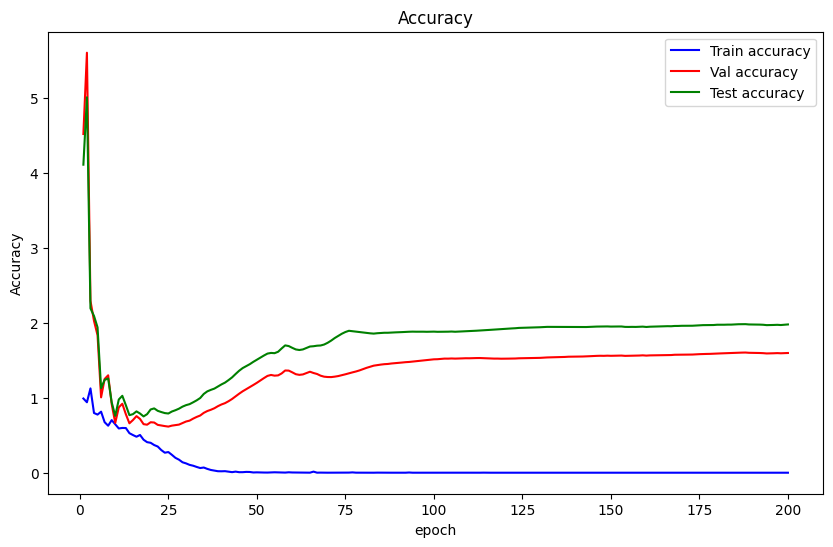

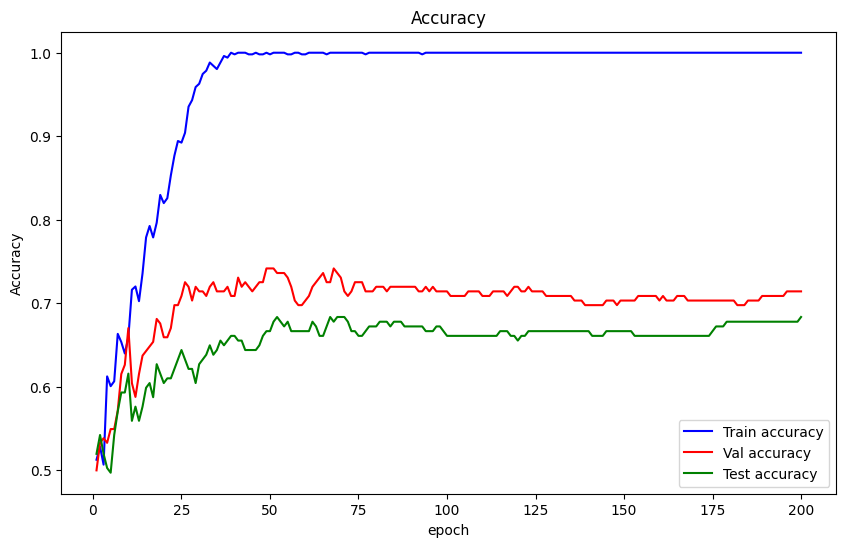



In fold  1
The best validaiton accuracy is:  0.7417582417582418
Happened at epoch:  68
The corresponding test accuracy 0.6779661016949152
The corresponding test AUC is:  0.7170076726342711




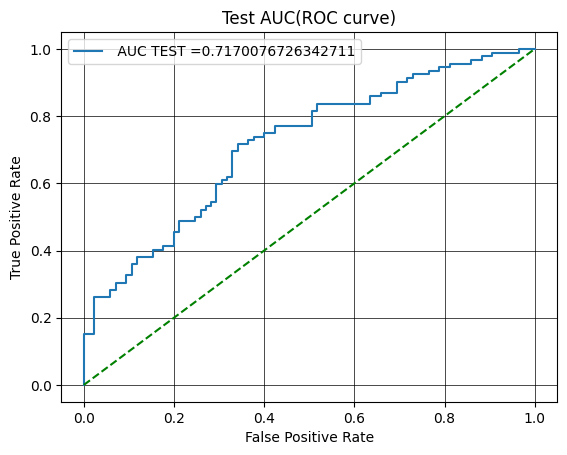

  + Number of params: 190274
Save models
Train Epoch: 1: train loss : 0.90697819	 train accuracy : 0.53564547	 val accuracy : 0.53672316	 test accuracy : 0.47126437	
Train Epoch: 2: train loss : 0.87773091	 train accuracy : 0.52986513	 val accuracy : 0.53107345	 test accuracy : 0.52873563	
Train Epoch: 3: train loss : 0.74827468	 train accuracy : 0.59152216	 val accuracy : 0.49152542	 test accuracy : 0.56896552	
Train Epoch: 4: train loss : 0.68002588	 train accuracy : 0.61657033	 val accuracy : 0.48587571	 test accuracy : 0.57471264	
Save models
Train Epoch: 5: train loss : 0.64757895	 train accuracy : 0.67244701	 val accuracy : 0.55932203	 test accuracy : 0.66666667	
Save models
Train Epoch: 6: train loss : 0.56654638	 train accuracy : 0.71483622	 val accuracy : 0.58192090	 test accuracy : 0.62643678	
Train Epoch: 7: train loss : 0.50667363	 train accuracy : 0.74181118	 val accuracy : 0.57062147	 test accuracy : 0.60344828	
Save models
Train Epoch: 8: train loss : 0.44555607	 train a

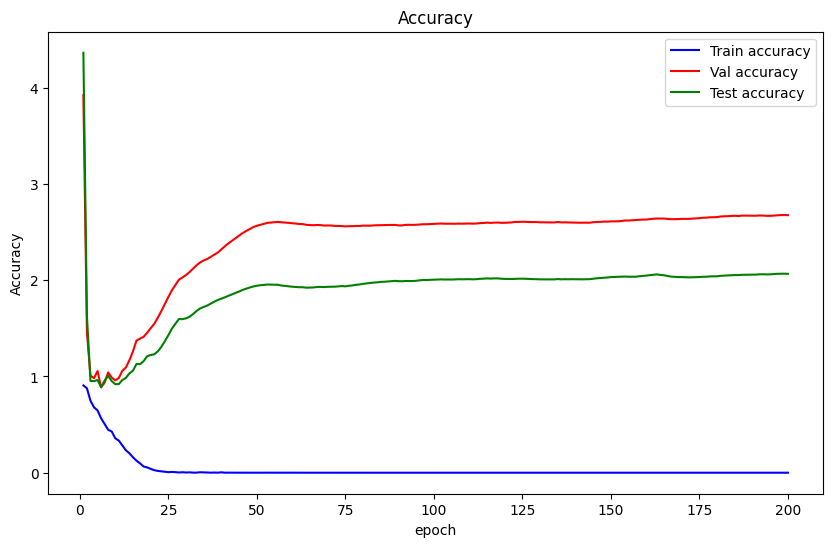

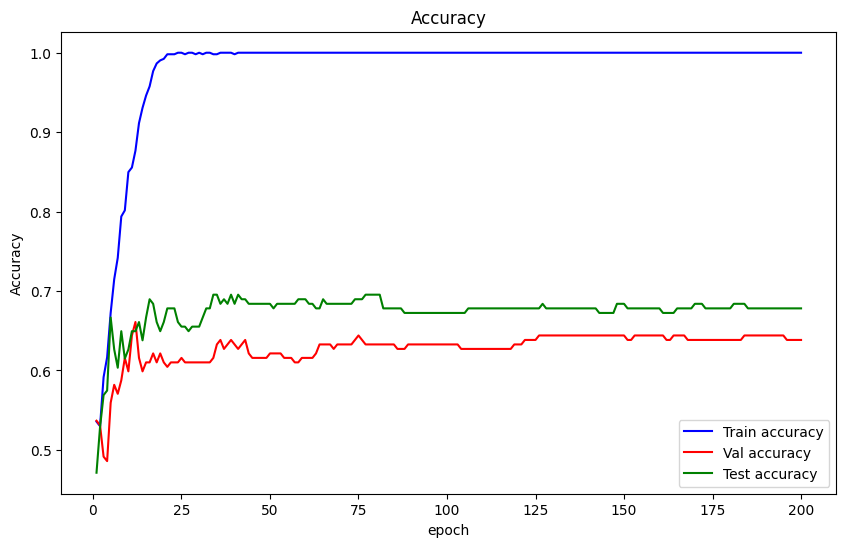



In fold  2
The best validaiton accuracy is:  0.6610169491525424
Happened at epoch:  12
The corresponding test accuracy 0.6494252873563219
The corresponding test AUC is:  0.692685517058277




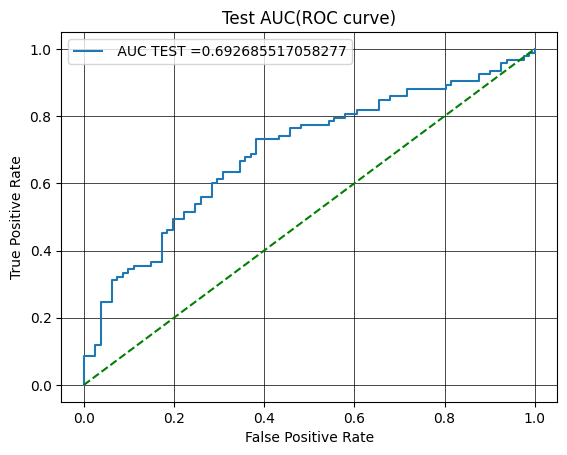

  + Number of params: 190274
Save models
Train Epoch: 1: train loss : 1.07045102	 train accuracy : 0.50950570	 val accuracy : 0.47701149	 test accuracy : 0.44705882	
Train Epoch: 2: train loss : 1.06316292	 train accuracy : 0.49049430	 val accuracy : 0.46551724	 test accuracy : 0.48235294	
Save models
Train Epoch: 3: train loss : 1.14405262	 train accuracy : 0.51711027	 val accuracy : 0.55747126	 test accuracy : 0.48823529	
Train Epoch: 4: train loss : 0.80619854	 train accuracy : 0.55323194	 val accuracy : 0.54597701	 test accuracy : 0.50000000	
Save models
Train Epoch: 5: train loss : 0.84027112	 train accuracy : 0.58365019	 val accuracy : 0.56321839	 test accuracy : 0.60000000	
Train Epoch: 6: train loss : 0.70109600	 train accuracy : 0.59695817	 val accuracy : 0.55172414	 test accuracy : 0.60588235	
Save models
Train Epoch: 7: train loss : 0.72120619	 train accuracy : 0.61026616	 val accuracy : 0.56321839	 test accuracy : 0.62352941	
Save models
Train Epoch: 8: train loss : 0.63040

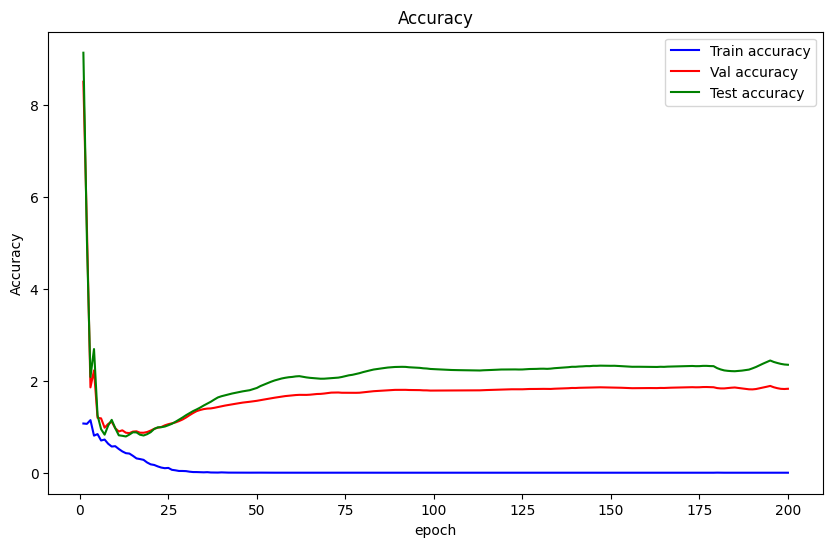

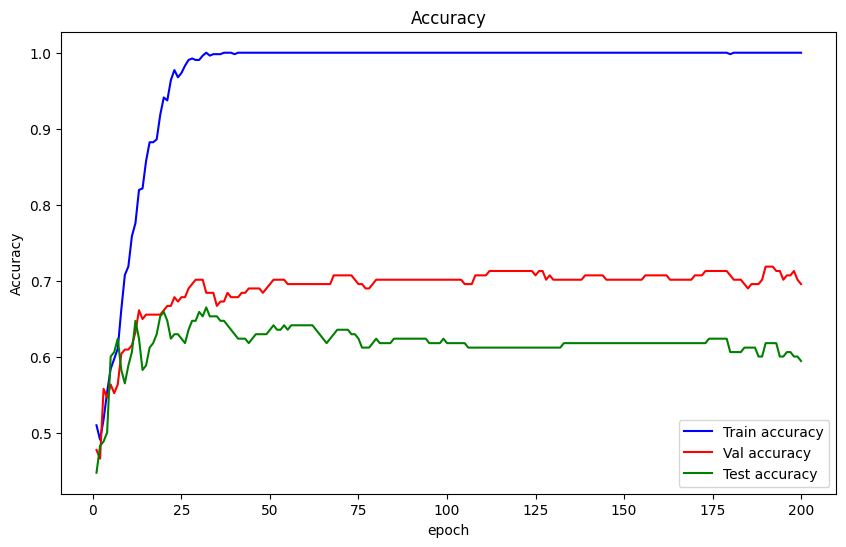



In fold  3
The best validaiton accuracy is:  0.7183908045977011
Happened at epoch:  192
The corresponding test accuracy 0.6176470588235294
The corresponding test AUC is:  0.6696528555431132




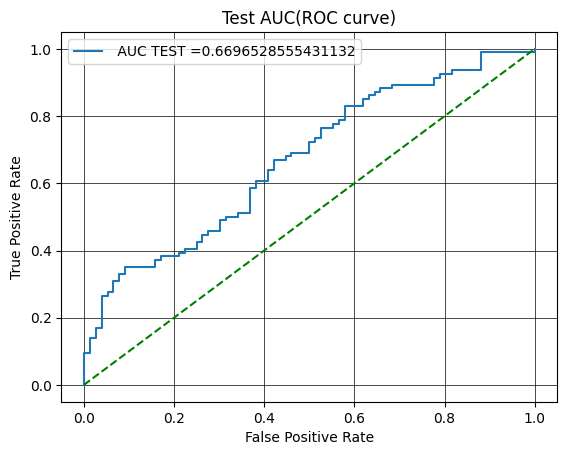

  + Number of params: 190274
Save models
Train Epoch: 1: train loss : 1.03335595	 train accuracy : 0.50093809	 val accuracy : 0.47058824	 test accuracy : 0.50898204	
Save models
Train Epoch: 2: train loss : 0.96684694	 train accuracy : 0.49718574	 val accuracy : 0.50000000	 test accuracy : 0.47305389	
Train Epoch: 3: train loss : 0.87488776	 train accuracy : 0.54971857	 val accuracy : 0.45882353	 test accuracy : 0.50299401	
Save models
Train Epoch: 4: train loss : 0.73350972	 train accuracy : 0.57786116	 val accuracy : 0.60000000	 test accuracy : 0.55688623	
Train Epoch: 5: train loss : 0.65317845	 train accuracy : 0.64165103	 val accuracy : 0.56470588	 test accuracy : 0.55089820	
Save models
Train Epoch: 6: train loss : 0.68090749	 train accuracy : 0.61726079	 val accuracy : 0.61176471	 test accuracy : 0.56886228	
Save models
Train Epoch: 7: train loss : 0.63096148	 train accuracy : 0.67166979	 val accuracy : 0.61176471	 test accuracy : 0.62874251	
Train Epoch: 8: train loss : 0.53713

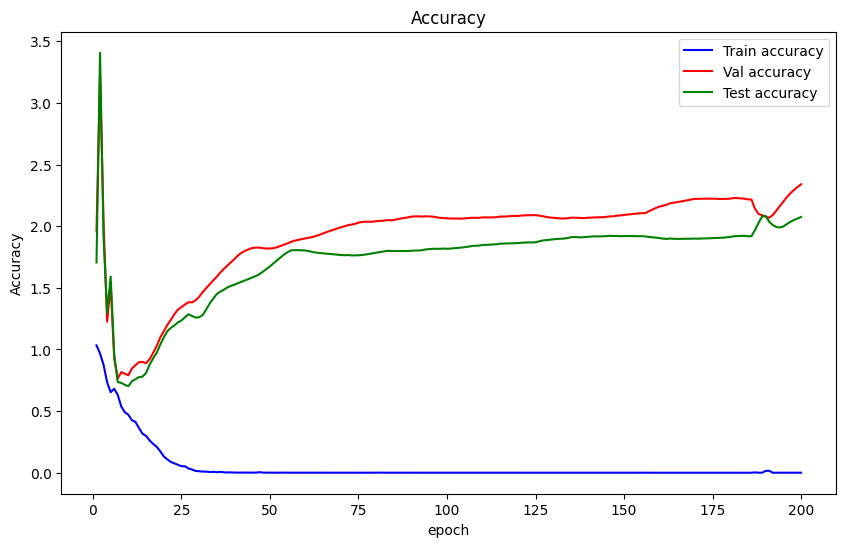

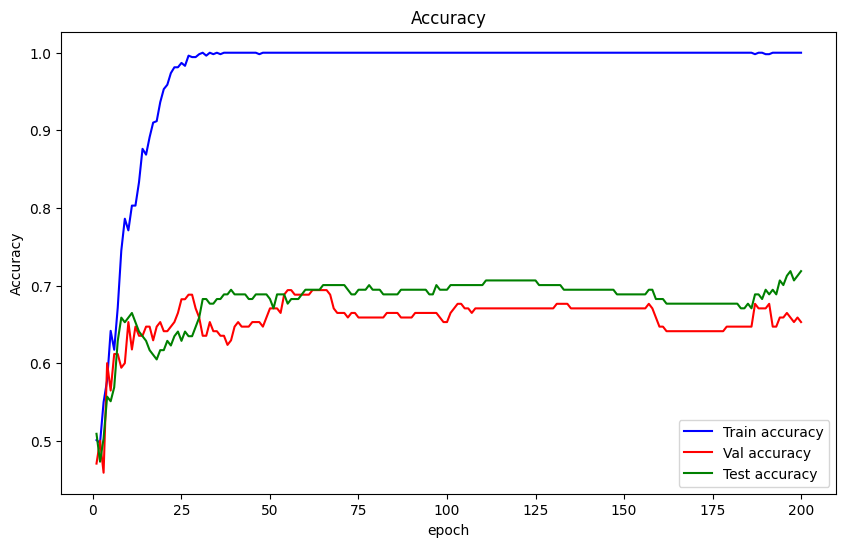



In fold  4
The best validaiton accuracy is:  0.6941176470588235
Happened at epoch:  66
The corresponding test accuracy 0.7005988023952096
The corresponding test AUC is:  0.7482608695652174




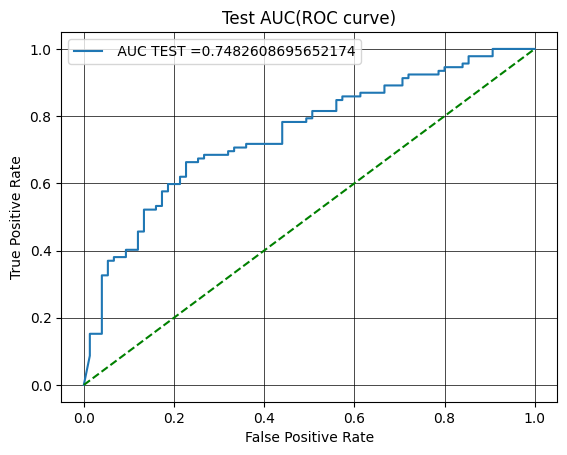

  + Number of params: 190274
Save models
Train Epoch: 1: train loss : 1.15514541	 train accuracy : 0.52399232	 val accuracy : 0.49700599	 test accuracy : 0.48901099	
Train Epoch: 2: train loss : 0.97200859	 train accuracy : 0.50671785	 val accuracy : 0.44910180	 test accuracy : 0.53296703	
Save models
Train Epoch: 3: train loss : 0.83966100	 train accuracy : 0.51439539	 val accuracy : 0.50898204	 test accuracy : 0.52197802	
Train Epoch: 4: train loss : 0.73128402	 train accuracy : 0.59884837	 val accuracy : 0.48502994	 test accuracy : 0.49450549	
Save models
Train Epoch: 5: train loss : 0.74329555	 train accuracy : 0.61036468	 val accuracy : 0.50898204	 test accuracy : 0.46703297	
Save models
Train Epoch: 6: train loss : 0.68763608	 train accuracy : 0.60844530	 val accuracy : 0.55688623	 test accuracy : 0.49450549	
Save models
Train Epoch: 7: train loss : 0.65774888	 train accuracy : 0.67370441	 val accuracy : 0.56886228	 test accuracy : 0.53846154	
Save models
Train Epoch: 8: train lo

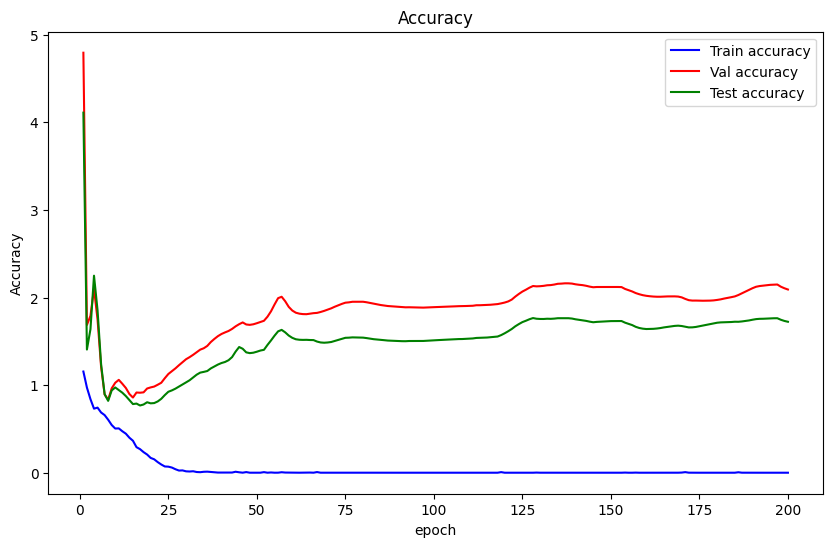

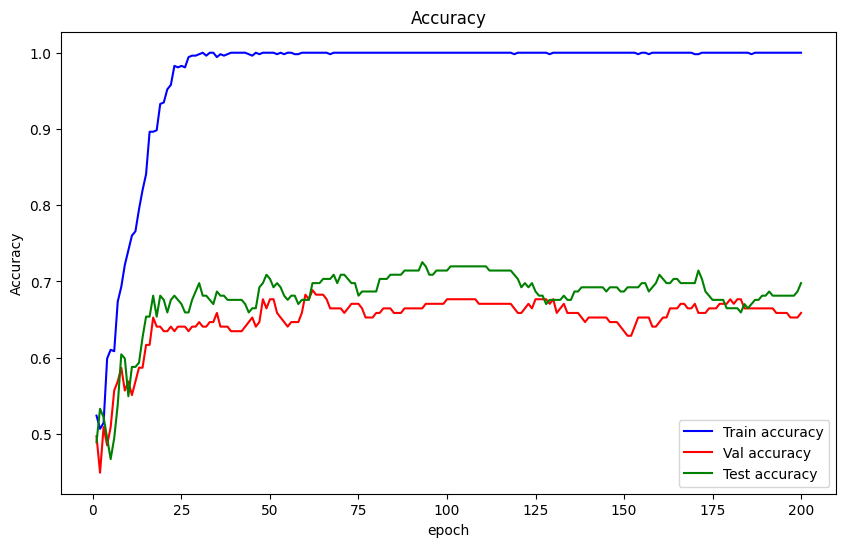



In fold  5
The best validaiton accuracy is:  0.688622754491018
Happened at epoch:  62
The corresponding test accuracy 0.6978021978021978
The corresponding test AUC is:  0.7404917635658914




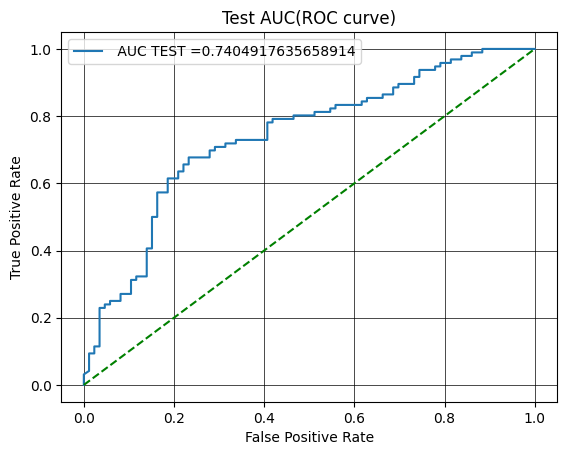

Finish 5-fold training


In [ ]:
########################################### Training ################################################
########################################### Training ################################################
########################################### Training ################################################
for fold in range(1, k_fold+1):
  model = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
  model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
  if args.cuda:
    model = model.cuda()
  optimizer = optim.Adam(model.parameters(), lr = args.lr)

  best_validation_accuracy = 0
  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []

  for epoch in range(1, args.nEpochs + 1):

    model, train_target, train_out, train_loss, val_target, val_out, val_loss, test_target, test_out, test_prob, test_loss = train(args, model, data[str(fold)], dist_train[str(fold)], dist_validation[str(fold)], dist_test[str(fold)], optimizer)

    train_accuracy = metrics.accuracy_score(train_target, train_out)
    val_accuracy = metrics.accuracy_score(val_target, val_out)
    test_accuracy = metrics.accuracy_score(test_target, test_out)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_val_out = val_out
      corresponding_test_accuracy = test_accuracy
      corresponding_test_out = test_out
      corresponding_test_prob = test_prob

      print('Save models')
      save_model(model, save_path, 'EV_GCN_'+str(fold))

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))

  if fold == 1:
    all_fold_val_label = val_target
    all_fold_val_out = corresponding_val_out
    all_fold_test_label = test_target
    all_fold_test_out = corresponding_test_out
    all_fold_test_prob = corresponding_test_prob
  else:
    all_fold_val_label = np.concatenate((all_fold_val_label, val_target),axis = 0)
    all_fold_val_out = np.concatenate((all_fold_val_out, corresponding_val_out),axis = 0)
    all_fold_test_label = np.concatenate((all_fold_test_label, test_target),axis = 0)
    all_fold_test_out = np.concatenate((all_fold_test_out, corresponding_test_out),axis = 0)
    all_fold_test_prob = np.concatenate((all_fold_test_prob, corresponding_test_prob),axis = 0)

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


  test_fpr, test_tpr, te_thresholds = roc_curve(test_target, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In fold ',str(fold))
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()

print('Finish 5-fold training')


The best validation accuracy is  0.7011494252873564
The corresponding test accuracy is  0.6689655172413793
The corresponding test AUC is:  0.7092682823151844


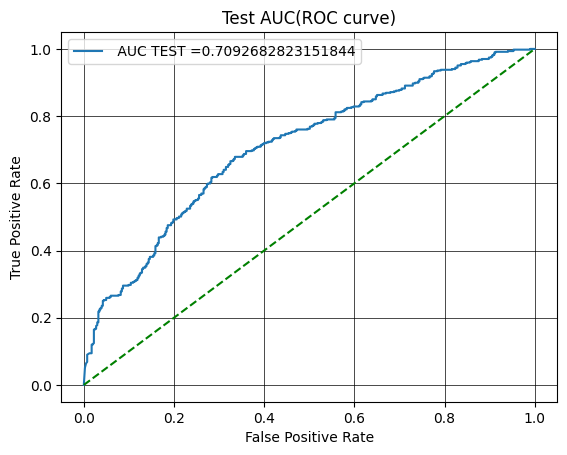

In [ ]:
val_accuracy = metrics.accuracy_score(all_fold_val_label, all_fold_val_out)
test_accuracy = metrics.accuracy_score(all_fold_test_label, all_fold_test_out)
test_fpr, test_tpr, te_thresholds = roc_curve(all_fold_test_label, all_fold_test_prob[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The best validation accuracy is ',val_accuracy)
print('The corresponding test accuracy is ',test_accuracy)
print('The corresponding test AUC is: ',test_auc)
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Ensemble  1
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

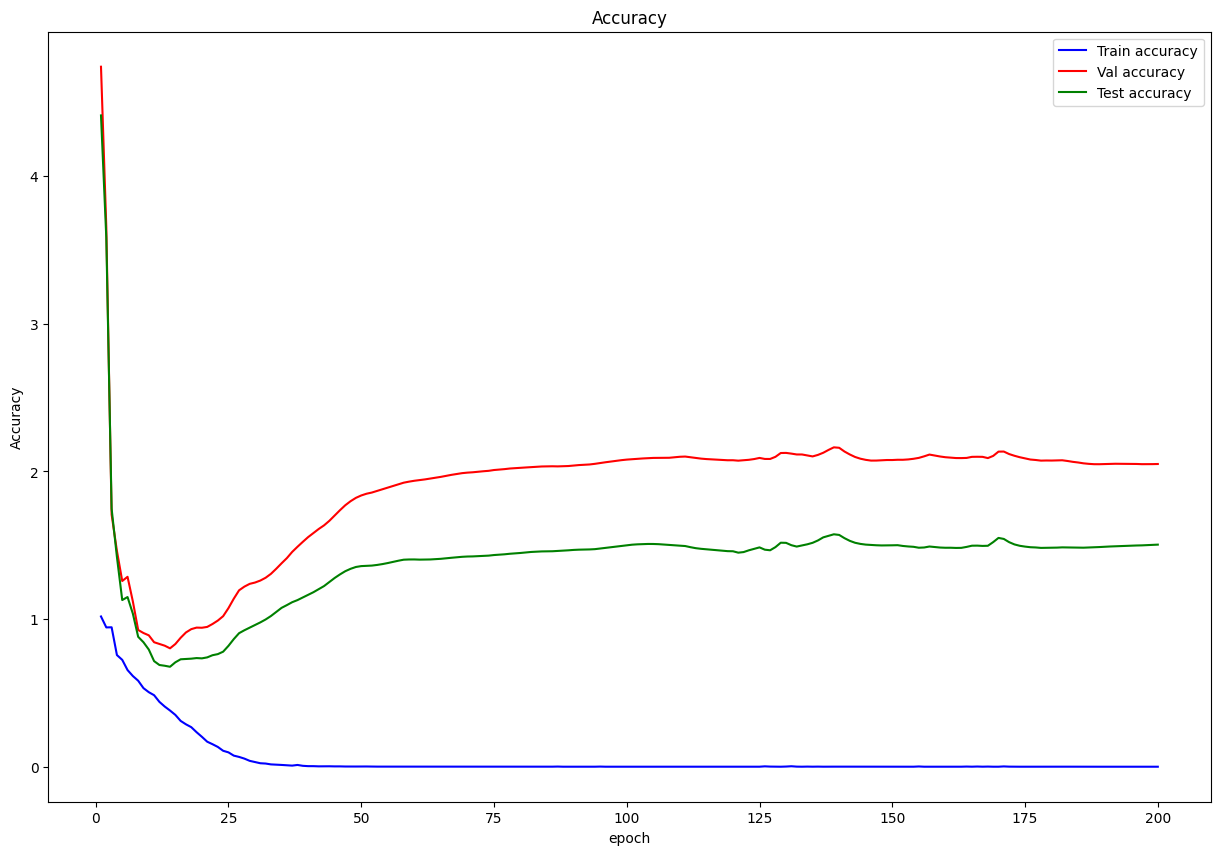

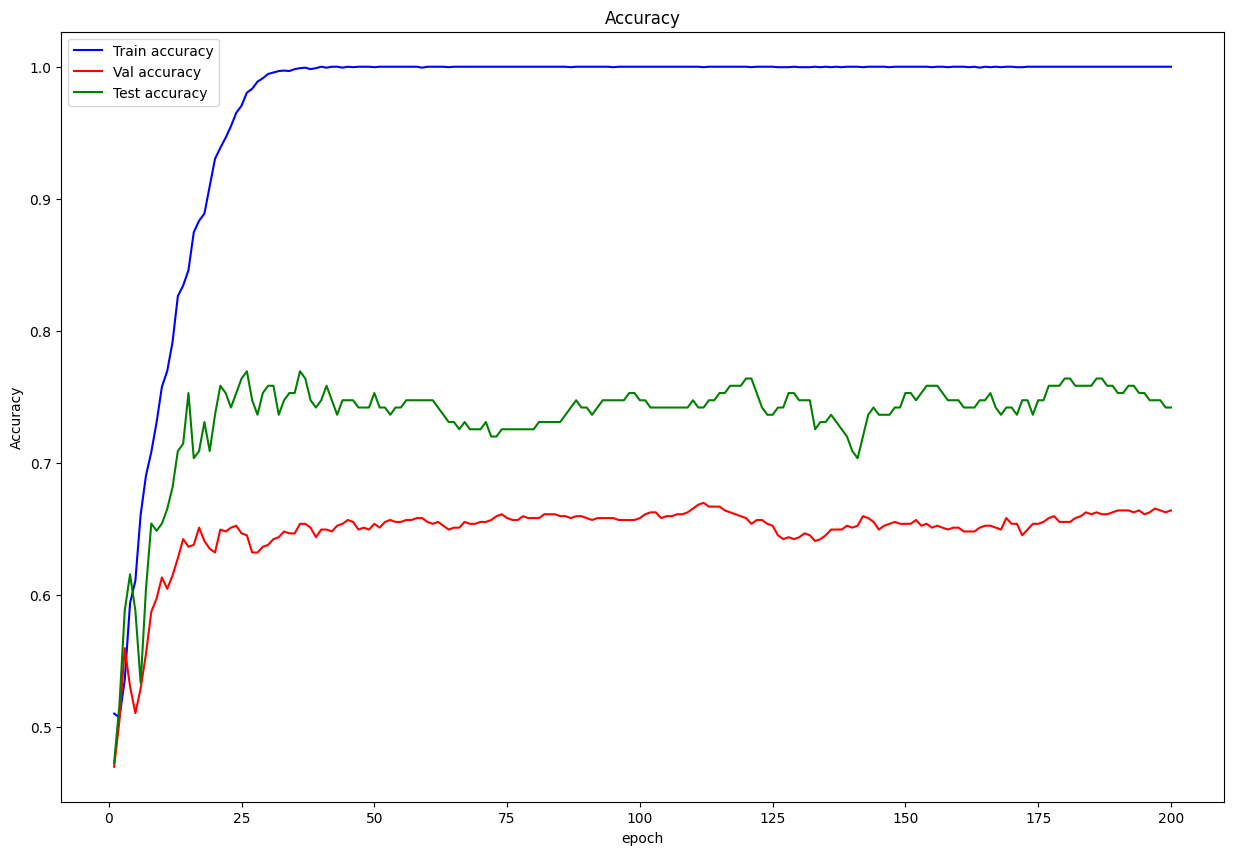



In ensemble  1
The best validaiton accuracy is:  0.6695652173913044
Happened at epoch:  112
The corresponding test accuracy 0.7417582417582418
The corresponding test AUC is:  0.8167393410852714




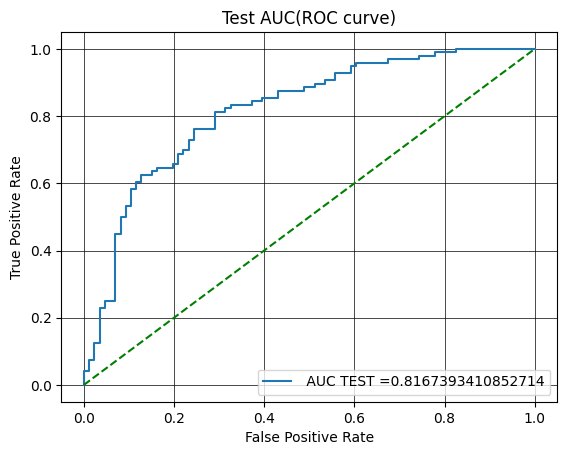



Ensemble  2
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

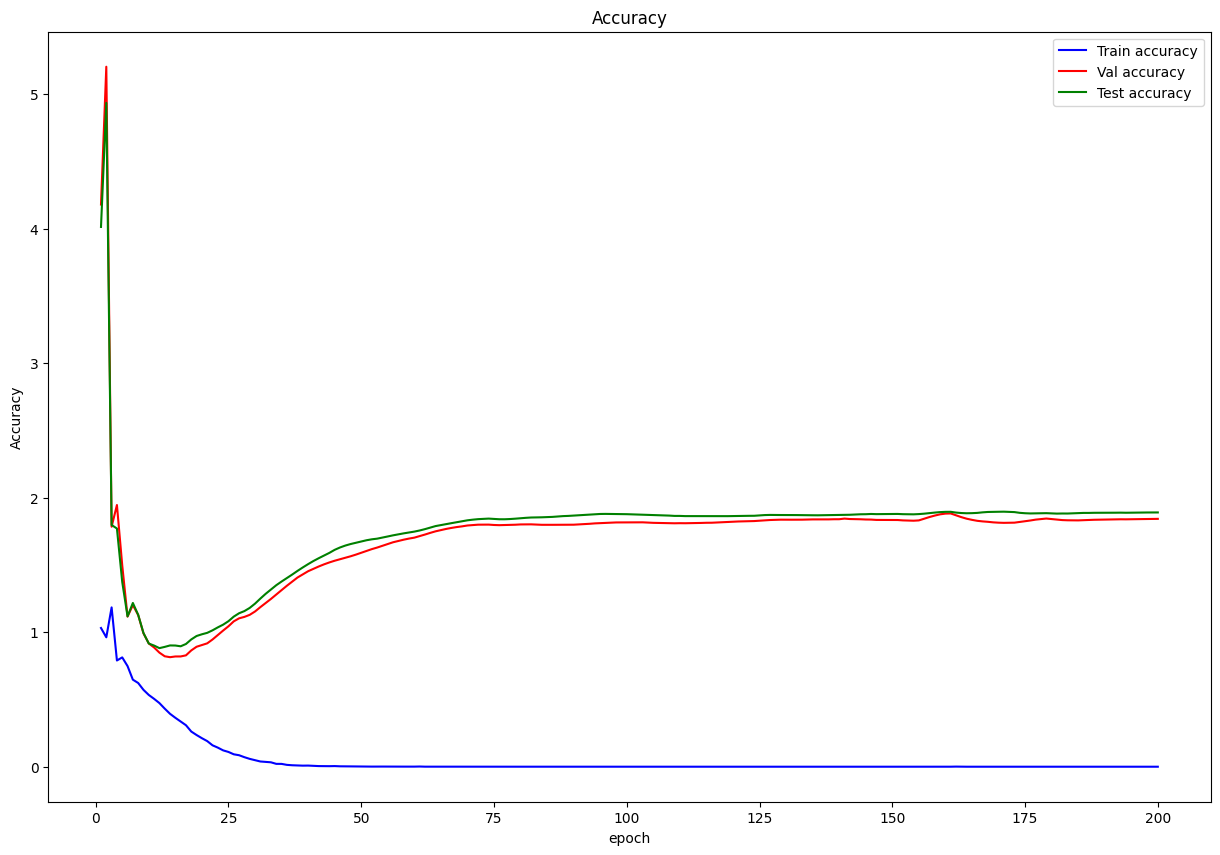

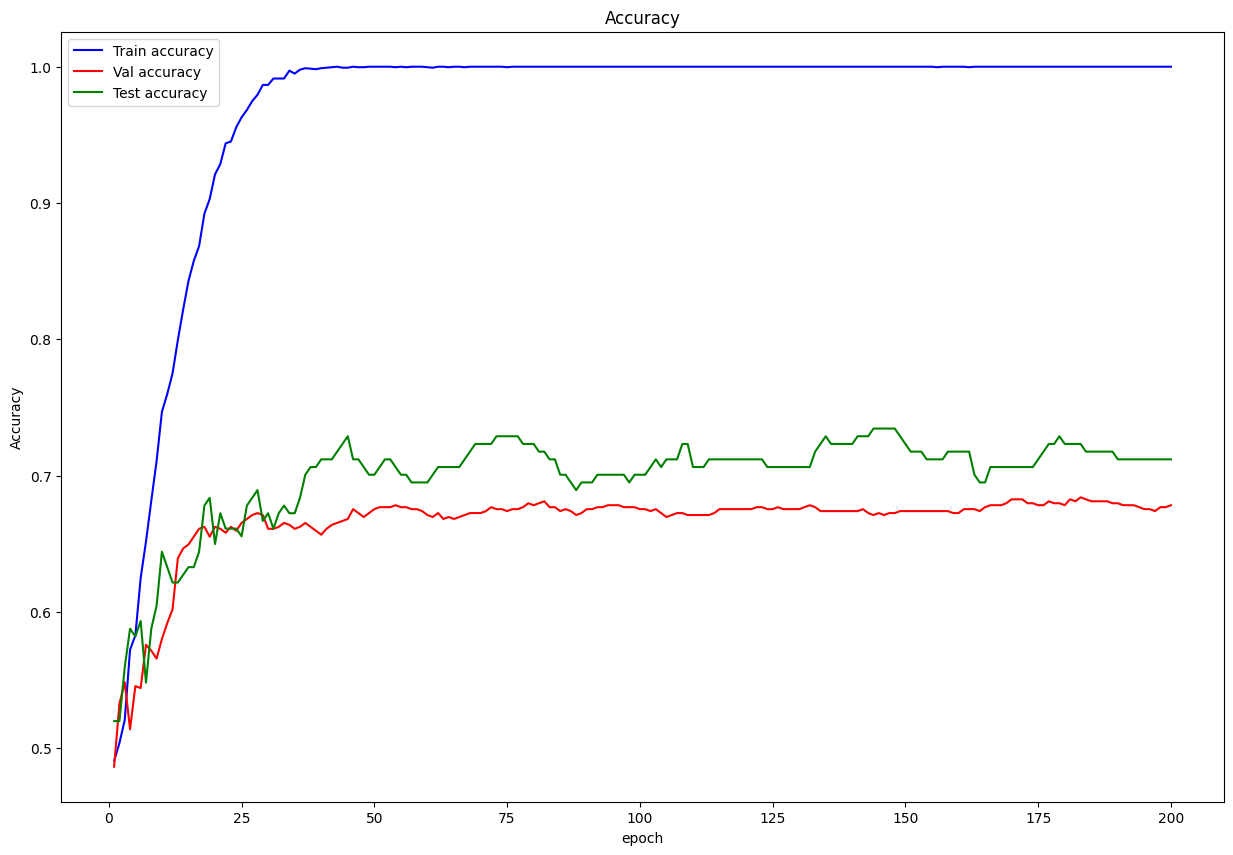



In ensemble  2
The best validaiton accuracy is:  0.683982683982684
Happened at epoch:  183
The corresponding test accuracy 0.7231638418079096
The corresponding test AUC is:  0.7487212276214834




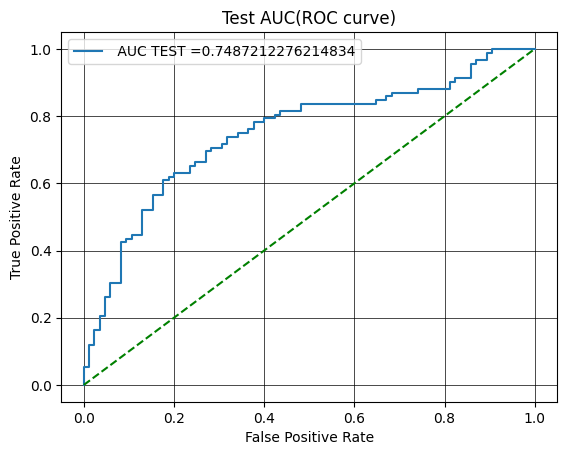



Ensemble  3
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

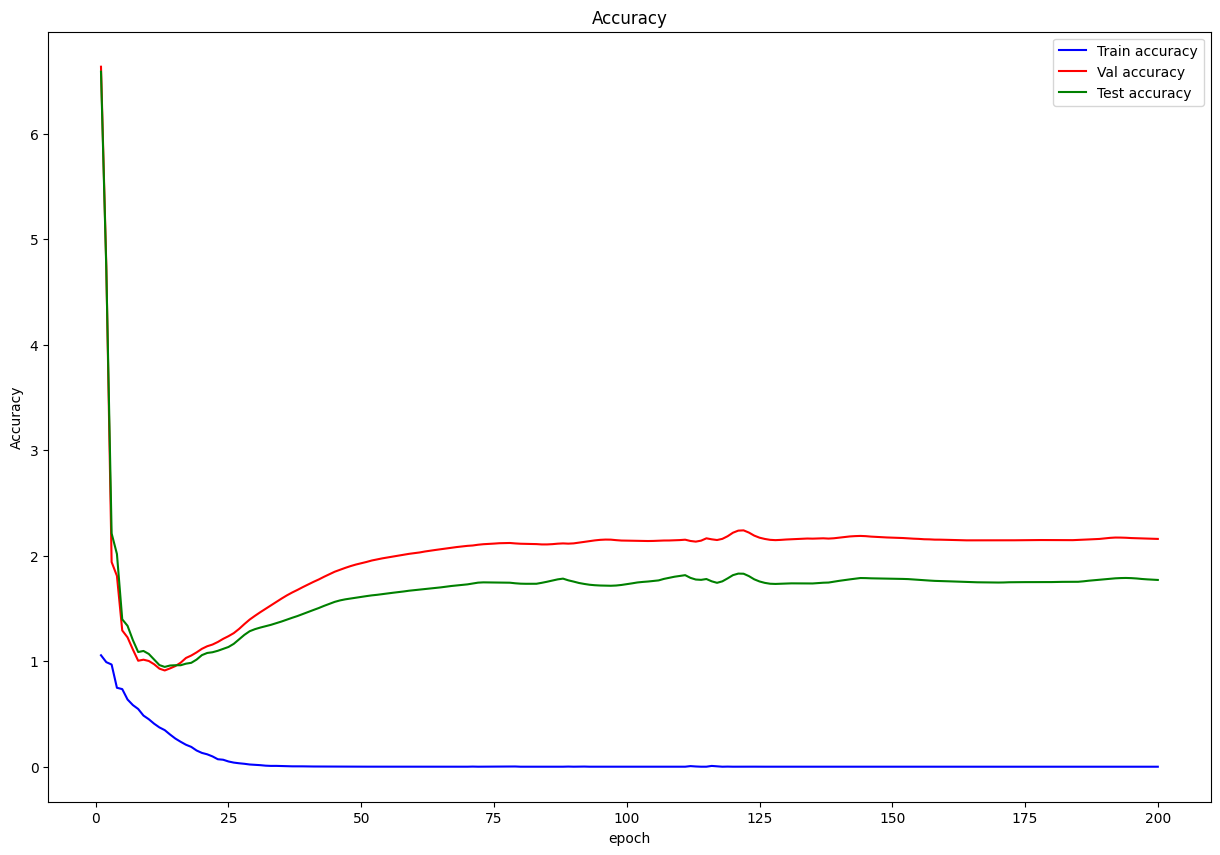

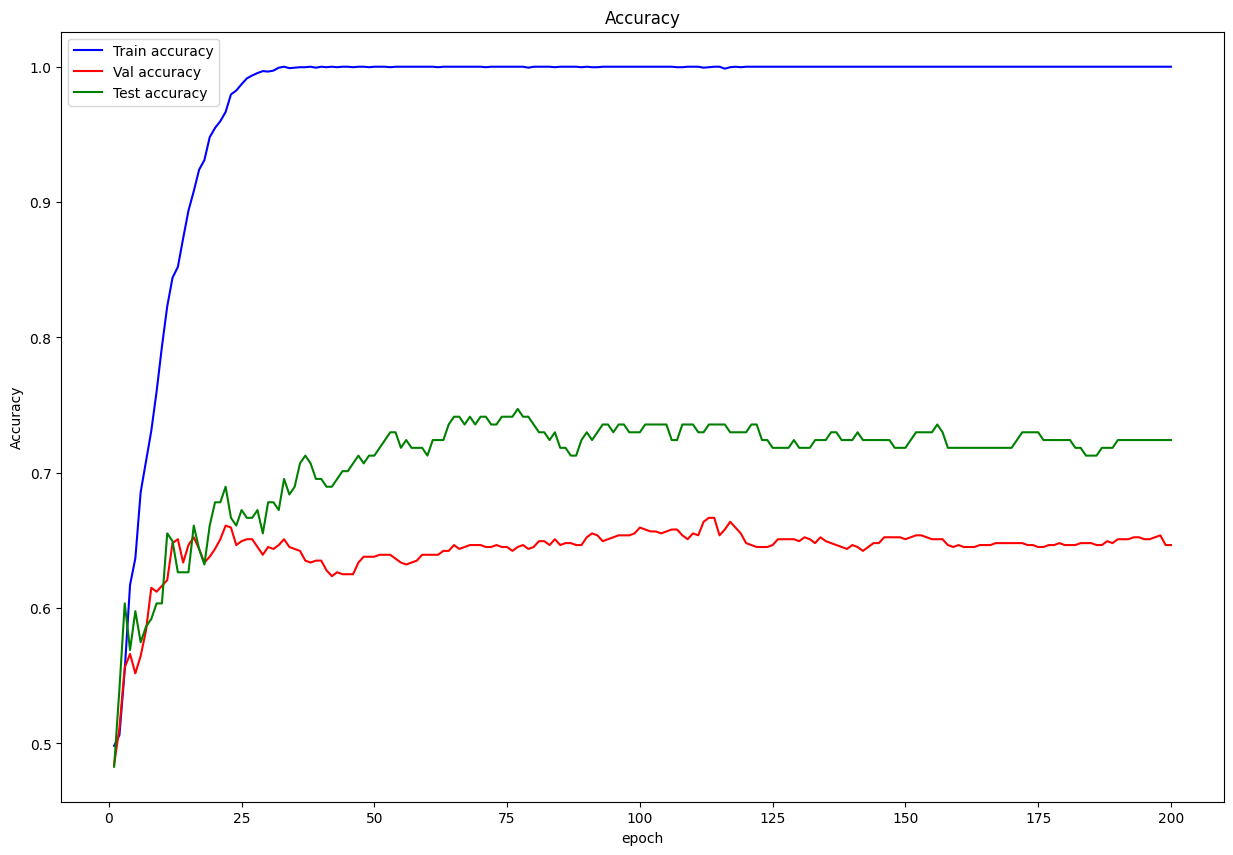



In ensemble  3
The best validaiton accuracy is:  0.6666666666666666
Happened at epoch:  114
The corresponding test accuracy 0.735632183908046
The corresponding test AUC is:  0.7804327625116155




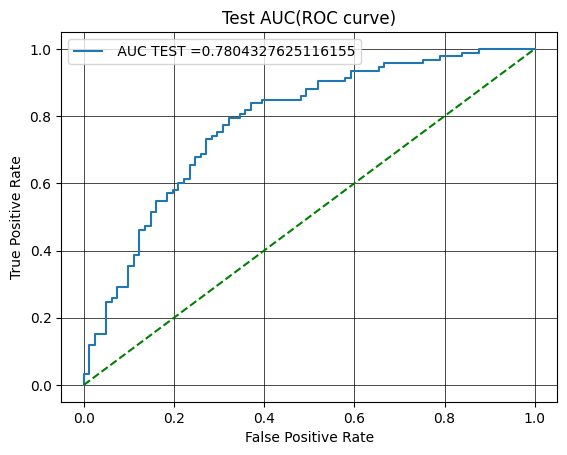



Ensemble  4
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

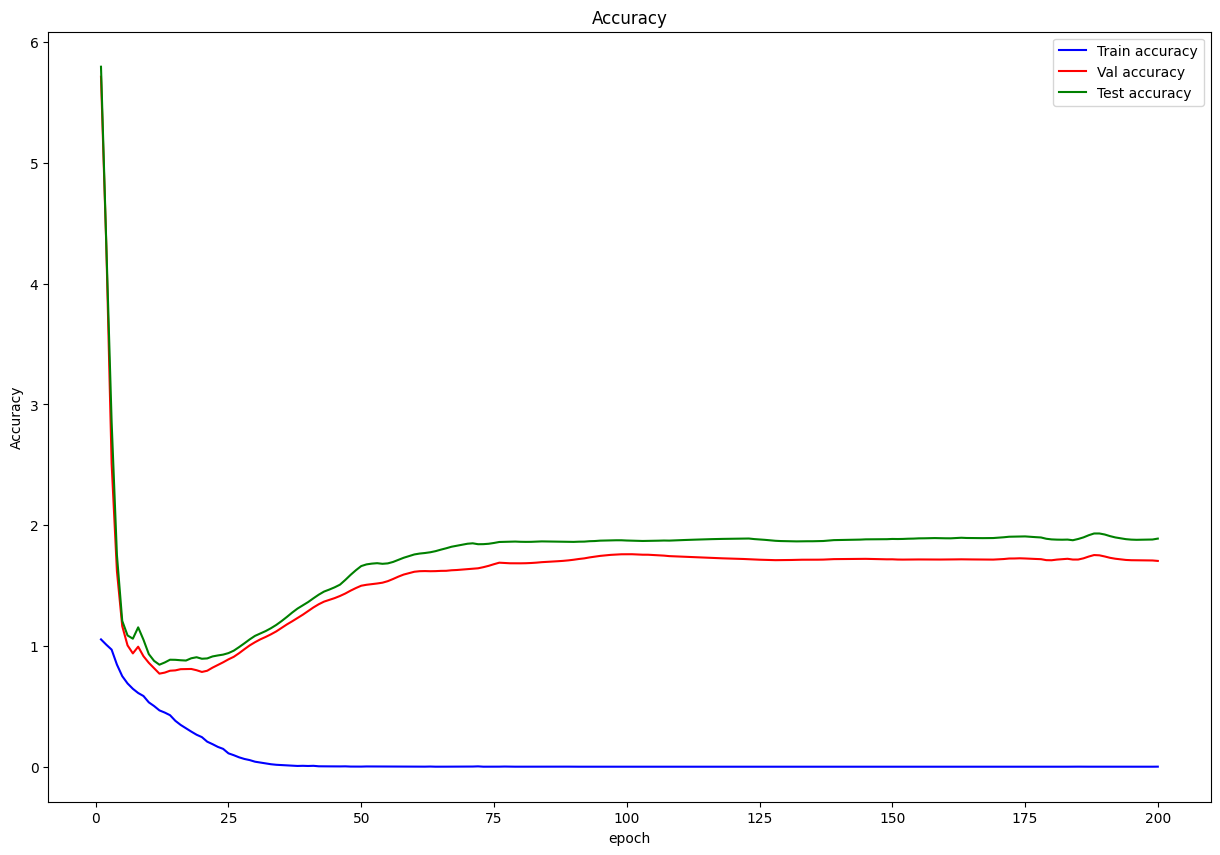

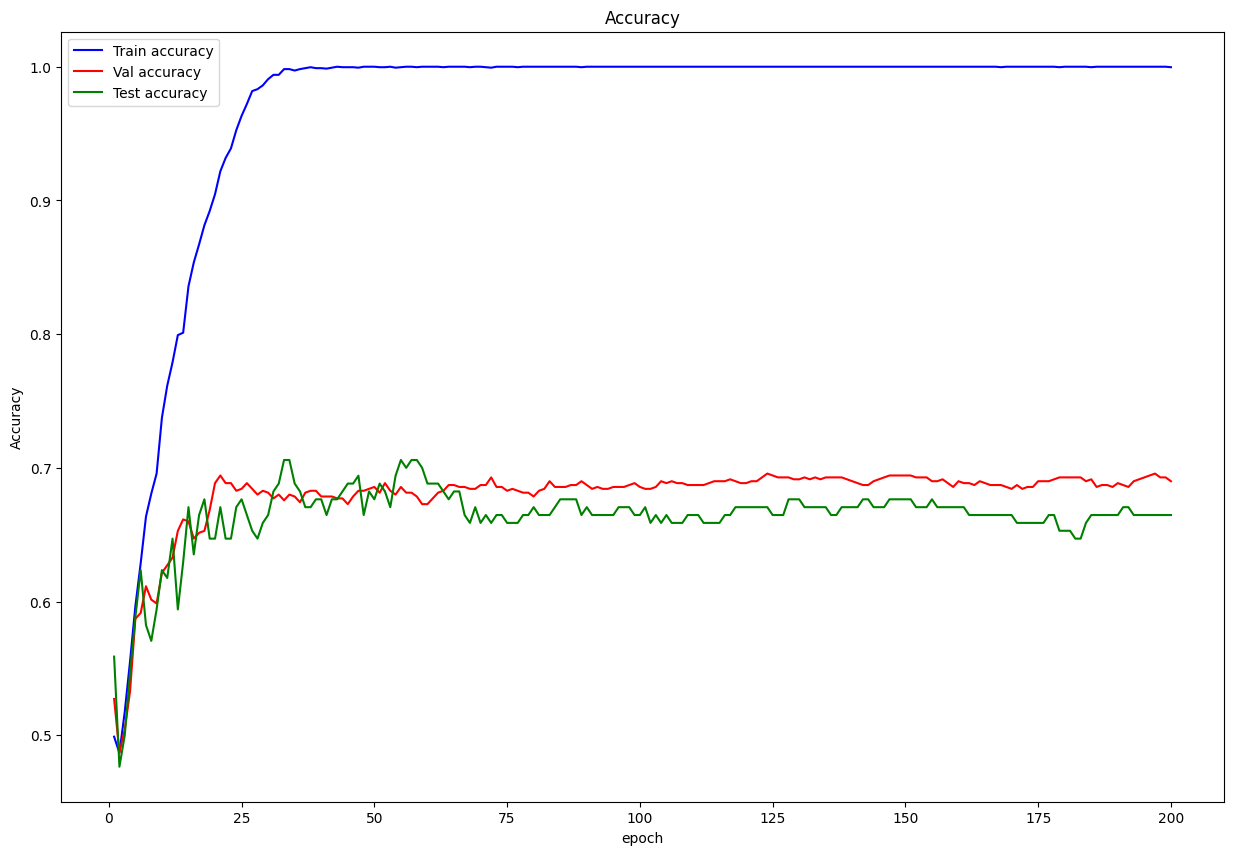



In ensemble  4
The best validaiton accuracy is:  0.6957142857142857
Happened at epoch:  197
The corresponding test accuracy 0.6647058823529411
The corresponding test AUC is:  0.7281634938409854




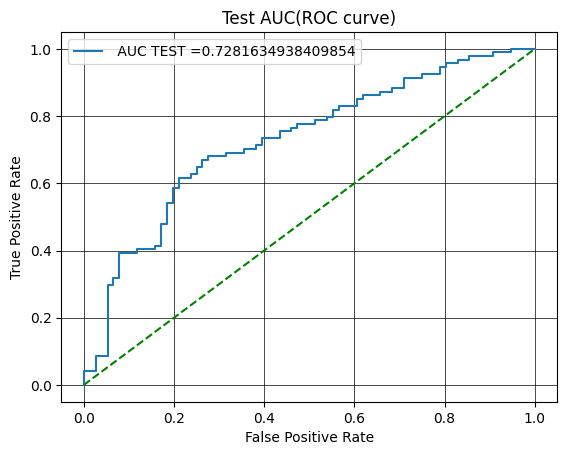



Ensemble  5
Fitting estimator with 19900 features.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

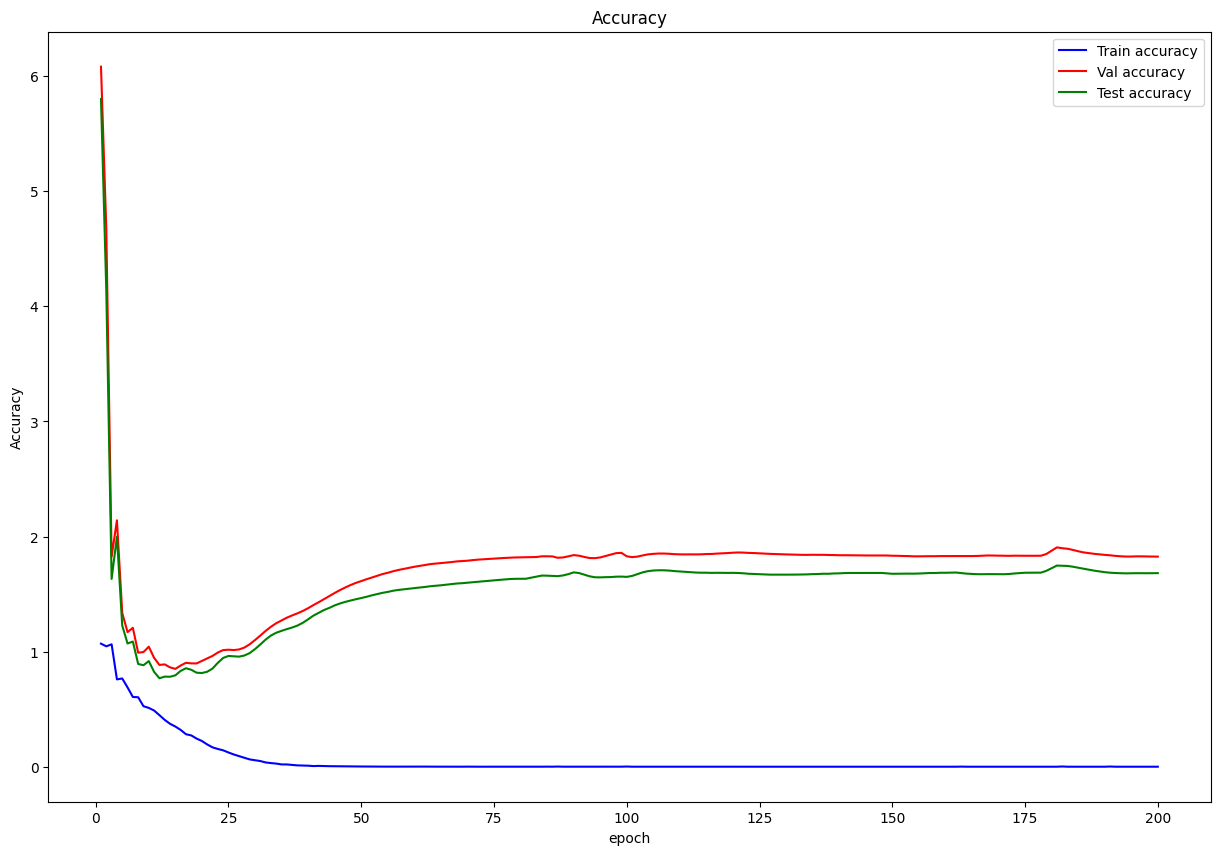

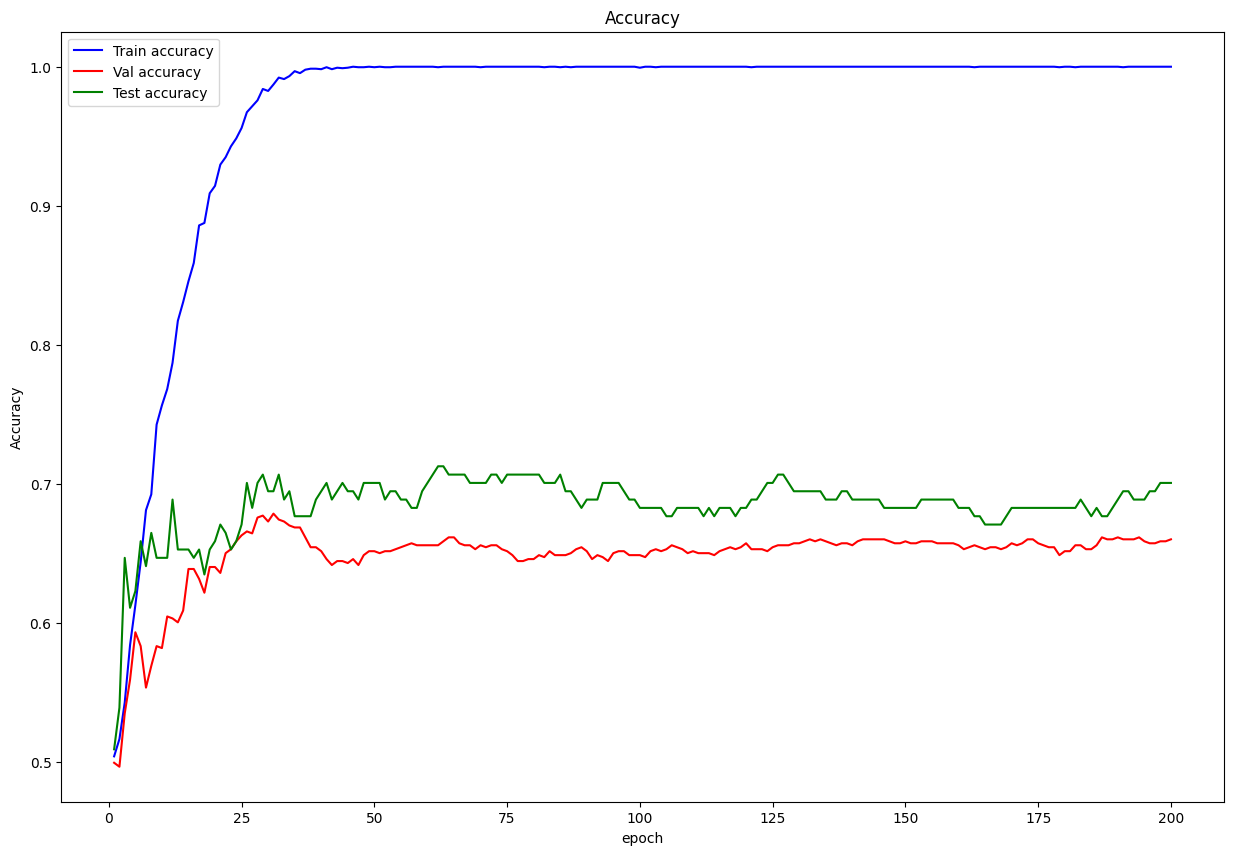



In ensemble  5
The best validaiton accuracy is:  0.6785206258890469
Happened at epoch:  31
The corresponding test accuracy 0.6946107784431138
The corresponding test AUC is:  0.7717391304347826




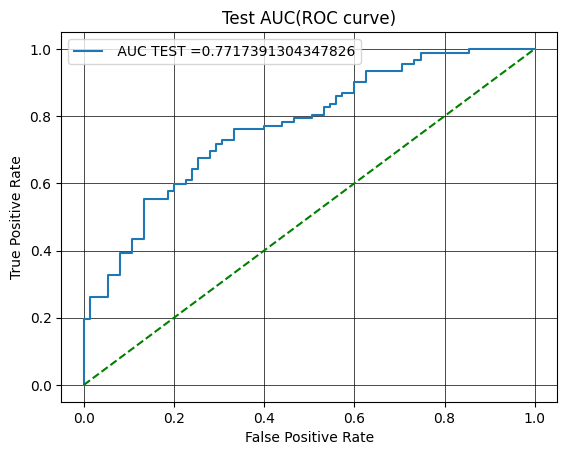



The Max voting test accuracy is:  0.7126436781609196
The test AUC is:  0.7694858156970474






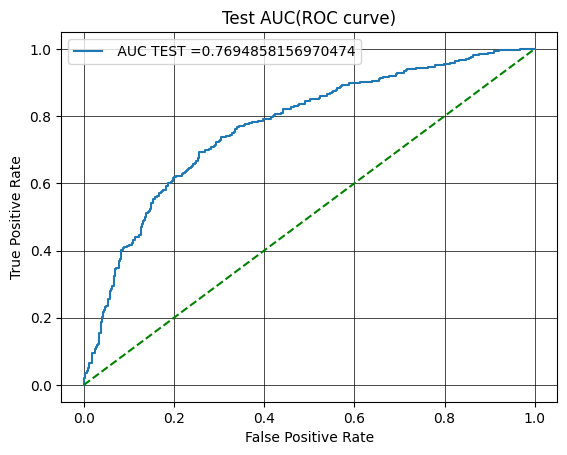

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/EV_GCN/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1


  data = {}

  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)
    ################################################# combine ##########################################
    if phe == True:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
      print(fold_data.shape)
    else:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
      print(fold_data.shape)

    n = fold_data.shape[0]
    num_edge = n * n
    edge_index = np.zeros([2, num_edge], dtype=np.int64)
    edgenet_input = np.zeros([num_edge, 2*phonetic_data.shape[1]], dtype=np.float32)
    aff_score = np.zeros(num_edge, dtype=np.float32)

    aff_adj = get_static_affinity_adj(fold_data, pd_dict)

    flatten_ind = 0
    for i in range(n):
      for j in range(n):
        edge_index[:, flatten_ind] = [i, j]
        edgenet_input[flatten_ind] = np.concatenate((phonetic_data[i], phonetic_data[j]))
        aff_score[flatten_ind] = aff_adj[i][j]
        flatten_ind += 1


    keep_ind = np.where(aff_score > 1.1)[0]
    edge_index = edge_index[:, keep_ind]
    edgenet_input = edgenet_input[keep_ind]
    edgenet_input = (edgenet_input- edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)

    data[str(fold)].append(fold_data)
    data[str(fold)].append(EV_GCN_labels)
    data[str(fold)].append(edge_index)
    data[str(fold)].append(edgenet_input)




  ############################################### Train ###############################################################
  ############################################### Train ###############################################################
  ############################################### Train ###############################################################

  model_1 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  model_2 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  model_3 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  model_4 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  model_5 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])

  gpu_ids = range(args.ngpu)
  model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
  model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
  model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
  model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
  model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)
  train = train_EV_GCN

  print('  + Number of params: {}'.format(
      sum([p.data.nelement() for p in model_1.parameters()])))
  if args.cuda:
      model_1 = model_1.cuda()
      model_2 = model_2.cuda()
      model_3 = model_3.cuda()
      model_4 = model_4.cuda()
      model_5 = model_5.cuda()

  optimizer_1 = optim.Adam(model_1.parameters(), lr = args.lr, weight_decay=args.wd)
  optimizer_2 = optim.Adam(model_2.parameters(), lr = args.lr, weight_decay=args.wd)
  optimizer_3 = optim.Adam(model_3.parameters(), lr = args.lr, weight_decay=args.wd)
  optimizer_4 = optim.Adam(model_4.parameters(), lr = args.lr, weight_decay=args.wd)
  optimizer_5 = optim.Adam(model_5.parameters(), lr = args.lr, weight_decay=args.wd)

  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []
  best_validation_accuracy = 0

  for epoch in range(1, args.nEpochs + 1):


    model_1, train_target_1, train_out_1, train_loss_1, val_target_1, val_out_1, val_loss_1, test_target_1, test_out_1, test_prob_1, test_loss_1 = train(args, model_1, data['1'], dist_train['1'], dist_validation['1'], dist_test['1'], optimizer_1)
    model_2, train_target_2, train_out_2, train_loss_2, val_target_2, val_out_2, val_loss_2, test_target_2, test_out_2, test_prob_2, test_loss_2 = train(args, model_2, data['2'], dist_train['2'], dist_validation['2'], dist_test['2'], optimizer_2)
    model_3, train_target_3, train_out_3, train_loss_3, val_target_3, val_out_3, val_loss_3, test_target_3, test_out_3, test_prob_3, test_loss_3 = train(args, model_3, data['3'], dist_train['3'], dist_validation['3'], dist_test['3'], optimizer_3)
    model_4, train_target_4, train_out_4, train_loss_4, val_target_4, val_out_4, val_loss_4, test_target_4, test_out_4, test_prob_4, test_loss_4 = train(args, model_4, data['4'], dist_train['4'], dist_validation['4'], dist_test['4'], optimizer_4)
    model_5, train_target_5, train_out_5, train_loss_5, val_target_5, val_out_5, val_loss_5, test_target_5, test_out_5, test_prob_5, test_loss_5 = train(args, model_5, data['5'], dist_train['5'], dist_validation['5'], dist_test['5'], optimizer_5)

    train_target_all = np.concatenate((train_target_1, train_target_2, train_target_3, train_target_4, train_target_5),axis = 0)
    train_out_all = np.concatenate((train_out_1, train_out_2, train_out_3, train_out_4, train_out_5),axis = 0)
    train_loss = (train_loss_1 + train_loss_2 + train_loss_3 + train_loss_4 + train_loss_5)/5
    val_target_all = np.concatenate((val_target_1, val_target_2, val_target_3, val_target_4, val_target_5),axis = 0)
    val_out_all = np.concatenate((val_out_1, val_out_2, val_out_3, val_out_4, val_out_5),axis = 0)
    val_loss = (val_loss_1 + val_loss_2 + val_loss_3 + val_loss_4 + val_loss_5)/5
    test_target_all = test_target_1 # test_target_1 = test_target_2 = test_target_3 = test_target_4 = test_target_5
    test_out_all = test_out_1 + test_out_2 + test_out_3 + test_out_4 + test_out_5
    test_prob_all = (test_prob_1 + test_prob_2 + test_prob_3 + test_prob_4 + test_prob_5)/5
    test_loss = (test_loss_1 + test_loss_2 + test_loss_3 + test_loss_4 + test_loss_5)/5

    test_results_binary = np.zeros_like((test_out_all))
    test_results_binary[test_out_all<2.5] = 0
    test_results_binary[test_out_all>=2.5] = 1

    train_accuracy = metrics.accuracy_score(train_target_all, train_out_all)
    val_accuracy = metrics.accuracy_score(val_target_all, val_out_all)
    test_accuracy = metrics.accuracy_score(test_target_all, test_results_binary)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_test_accuracy = test_accuracy
      corresponding_test_prob = test_prob_all
      corresponding_test_labels = test_target_all
      corresponding_test_out = test_results_binary
      print('Save models')

      save_model(model_1, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_1')
      save_model(model_2, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_2')
      save_model(model_3, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_3')
      save_model(model_4, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_4')
      save_model(model_5, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_5')

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  test_fpr, test_tpr, te_thresholds = roc_curve(corresponding_test_labels, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In ensemble ',ensemble_fold+1)
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()


  dist_ensemble_test_label[str(ensemble_fold+1)] = corresponding_test_labels
  dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_out
  dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_prob
  print('\n')

  torch.cuda.empty_cache()

test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'],  dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'],  dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'],  dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

